# Data Ingestion

Downloading Data from Kaggle

In [1]:
# setting up to use kaggle dataset

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d adityajn105/flickr8k


Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
 96% 1.00G/1.04G [00:04<00:00, 173MB/s]
100% 1.04G/1.04G [00:05<00:00, 214MB/s]


In [3]:
mkdir dataset

In [4]:
!unzip flickr8k.zip



Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

In [5]:
with open("/content/captions.txt","r") as f :
  lines=f.readlines()
  print(lines[:10])


['image,caption\n', '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n', '1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n', '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n', '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n', '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n', '1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n', '1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .\n', '1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .\n', '1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .\n']


# Data Preprocessing

# first lets get the tabular form

In [6]:
import pandas as pd

In [7]:
data=pd.read_csv("/content/captions.txt")

In [8]:
data.head(10)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


In [9]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from textwrap import wrap

reading image : loading -> normalizing

In [10]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

In [11]:
def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    plt.subplot(5 , 5, 1)
    plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
    image = readImage(f"/content/Images/{temp_df.image[1]}")
    print(type(image))
    plt.imshow(image)
    plt.title("\n".join(wrap(temp_df.caption[1], 20)))
    plt.axis("off")

<class 'numpy.ndarray'>


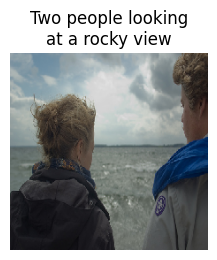

In [12]:
display_images(data.sample(15))

### Text PReprocessing

In [13]:
def text_preprocessing(data):
    import re
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
    data['caption'] = data['caption'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())
    data['caption'] = "startseq " + data['caption'] + " endseq"
    return data

In [14]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
 'startseq a girl going into a wooden building endseq',
 'startseq a little girl climbing into a wooden playhouse endseq',
 'startseq a little girl climbing the stairs to her playhouse endseq',
 'startseq a little girl in a pink dress going into a wooden cabin endseq',
 'startseq a black dog and a spotted dog are fighting endseq',
 'startseq a black dog and a tricolored dog playing with each other on the road endseq',
 'startseq a black dog and a white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

# Tokenization

tokenizing the texts and converting them into tokens (numbers)

using keras's tokenizer

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [16]:
tokenizer=Tokenizer()

In [17]:
tokenizer.fit_on_texts(captions)

In [18]:
tokenizer.word_index

{'a': 1,
 'startseq': 2,
 'endseq': 3,
 'in': 4,
 'the': 5,
 'on': 6,
 'is': 7,
 'and': 8,
 'dog': 9,
 'with': 10,
 'man': 11,
 'of': 12,
 'two': 13,
 'white': 14,
 'black': 15,
 'boy': 16,
 'are': 17,
 'woman': 18,
 'girl': 19,
 'to': 20,
 'wearing': 21,
 'at': 22,
 'people': 23,
 'water': 24,
 'red': 25,
 'young': 26,
 'brown': 27,
 'an': 28,
 'his': 29,
 'blue': 30,
 'dogs': 31,
 'running': 32,
 'through': 33,
 'playing': 34,
 'while': 35,
 'down': 36,
 'shirt': 37,
 'standing': 38,
 'ball': 39,
 'little': 40,
 'grass': 41,
 'child': 42,
 'person': 43,
 'snow': 44,
 'jumping': 45,
 'over': 46,
 'front': 47,
 'three': 48,
 'sitting': 49,
 'holding': 50,
 'field': 51,
 'small': 52,
 'up': 53,
 'by': 54,
 'large': 55,
 'green': 56,
 'group': 57,
 'one': 58,
 'yellow': 59,
 'her': 60,
 'walking': 61,
 'children': 62,
 'men': 63,
 'into': 64,
 'air': 65,
 'beach': 66,
 'near': 67,
 'mouth': 68,
 'jumps': 69,
 'another': 70,
 'for': 71,
 'street': 72,
 'runs': 73,
 'its': 74,
 'from': 75,

In [19]:
vocab_size=len(tokenizer.word_index)+1

In [20]:
vocab_size

8781

In [21]:
max_len_sentence=max(len(caption.split()) for caption in captions)

In [22]:
max_len_sentence

37

---
number of words 8496
---
max_len=42

In [23]:
images=data['image']
num_images=len(images)

In [24]:
num_images

40455

In [25]:
len(data['caption'])

40455

In [26]:
def gimme_split(n, data_df):
    unique_images = data_df['image'].unique()
    split_amt = int(n * len(unique_images))

    train_images = unique_images[:split_amt]
    test_images = unique_images[split_amt:]

    train = data_df[data_df['image'].isin(train_images)].reset_index(drop=True)
    test = data_df[data_df['image'].isin(test_images)].reset_index(drop=True)

    return train, test

In [27]:
train, test = gimme_split(0.85, data)

In [28]:
len(train)

34385

In [29]:
len(test)

6070

In [30]:
type(train)

pandas.core.frame.DataFrame

In [31]:
train.head(3)

,image,caption
0,1000268201_693b08cb0e.jpg,startseq a child in a pink dress is climbing u...
1,1000268201_693b08cb0e.jpg,startseq a girl going into a wooden building e...
2,1000268201_693b08cb0e.jpg,startseq a little girl climbing into a wooden ...


In [32]:
train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

In [33]:
test.head(3)

,image,caption
0,3688858505_e8afd1475d.jpg,startseq a blond girl in a green dress and ela...
1,3688858505_e8afd1475d.jpg,startseq a few people with a girl standing up ...
2,3688858505_e8afd1475d.jpg,startseq a girl is wear a green dress endseq


# feature Extraction


In [34]:
# we will use resnet50: having 2048 embedding
# good for low data

In [42]:
import pickle

In [43]:
with open("features.pkl","rb") as f:
  features=pickle.load(f)


In [44]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

In [45]:
model=ResNet50()
feature_extractor=Model(inputs=model.input,outputs=model.layers[-2].output)



In [46]:
from tqdm import tqdm

In [47]:
import os
import numpy as np

In [ ]:
from tensorflow.keras.layers import BatchNormalization

In [ ]:
img_size=224
features={}
image_path="/content/Images/"

#iterating over all images and extracting features
for image in tqdm(data["image"]):
  img=load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
  img=img_to_array(img)
  img=img/255.
  img=np.expand_dims(img,axis=0)
  feature=feature_extractor.predict(img,verbose=0)
  features[image]=feature

  0%|          | 196/40455 [00:21<1:14:15,  9.04it/s]


KeyboardInterrupt: 

# Data for the model

input will be like :
img embedding - text embedding for .training:
text_embedding passed 1 by 1

(image embedding, caption tokens)

Model learning :

like in transformers/seq2seq

model will see past words(captions) along with img embedding and predict next word


Inference (generate captions)

-Image → Embedding (same CNN).

-Start with <start> token.

-Loop until <end> token or max length:

-Feed image embedding + generated words so far.

-Model predicts next word.

-Append that word to the caption.

-Final caption = sequence of predicted words.

In [48]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [49]:
class imgData2modelData(Sequence):
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, vocab_size, max_length, features, shuffle=True):
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        self.indexes = np.arange(self.n)

        if self.shuffle:
            np.random.shuffle(self.indexes)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self, index):
        # Use shuffled indexes
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch = self.df.iloc[indexes]
        X1, X2, y = self.__getdata(batch)
        return (np.array(X1), np.array(X2)), np.array(y)

    def __getdata(self, batch):
        X1, X2, y = [], [], []

        for idx, row in batch.iterrows():
            image = row[self.X_col]
            caption = row[self.y_col]

            feature = self.features[image][0]
            seq = self.tokenizer.texts_to_sequences([caption])[0]

            for i in range(1, len(seq)):
                in_seq = seq[:i]
                out_seq = seq[i]

                in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]

                X1.append(feature)
                X2.append(in_seq)
                y.append(out_seq)

        return X1, X2, y



In [50]:
image_path="/content/Images"
import numpy as np

In [51]:

def create_train_val_split(train_data, val_split=0.2):
    val_size = int(len(train_data) * val_split)
    val_data = train_data.tail(val_size).reset_index(drop=True)
    train_data = train_data.head(len(train_data) - val_size).reset_index(drop=True)
    return train_data, val_data


train_data, val_data = create_train_val_split(train, val_split=0.2)


train_generator = imgData2modelData(
    df=train_data,
    X_col='image',
    y_col='caption',
    batch_size=32,
    directory=image_path,
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_len_sentence,
    features=features,
    shuffle=True
)

val_generator = imgData2modelData(
    df=val_data,
    X_col='image',
    y_col='caption',
    batch_size=32,  # REDUCED batch size
    directory=image_path,
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_len_sentence,
    features=features,
    shuffle=False
)


# Modelling

In [55]:
from tensorflow.keras.layers import Input,Dense,Dropout,LSTM,concatenate,Embedding,Reshape,add,BatchNormalization

In [56]:

input1 = Input(shape=(2048,))
input2 = Input(shape=(max_len_sentence,))

# Image features with batch normalization
Ifeatures = Dense(256, activation='relu')(input1)
Ifeatures = BatchNormalization()(Ifeatures)
Ifeatures = Dropout(0.3)(Ifeatures)
Ifeatures_reshaped = Reshape((1, 256))(Ifeatures)

Sfeatures = Embedding(vocab_size, 256, mask_zero=False)(input2)
Sfeatures = Dropout(0.3)(Sfeatures)

merged = concatenate([Ifeatures_reshaped, Sfeatures], axis=1)

sentence_features = LSTM(256, dropout=0.3, recurrent_dropout=0.3)(merged)  # ADD dropouts

x = Dropout(0.5)(sentence_features)
x = add([x, Ifeatures])
x = BatchNormalization()(x)

x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1, input2], outputs=output)


In [57]:

caption_model.compile(loss="categorical_crossentropy",optimizer="adam")

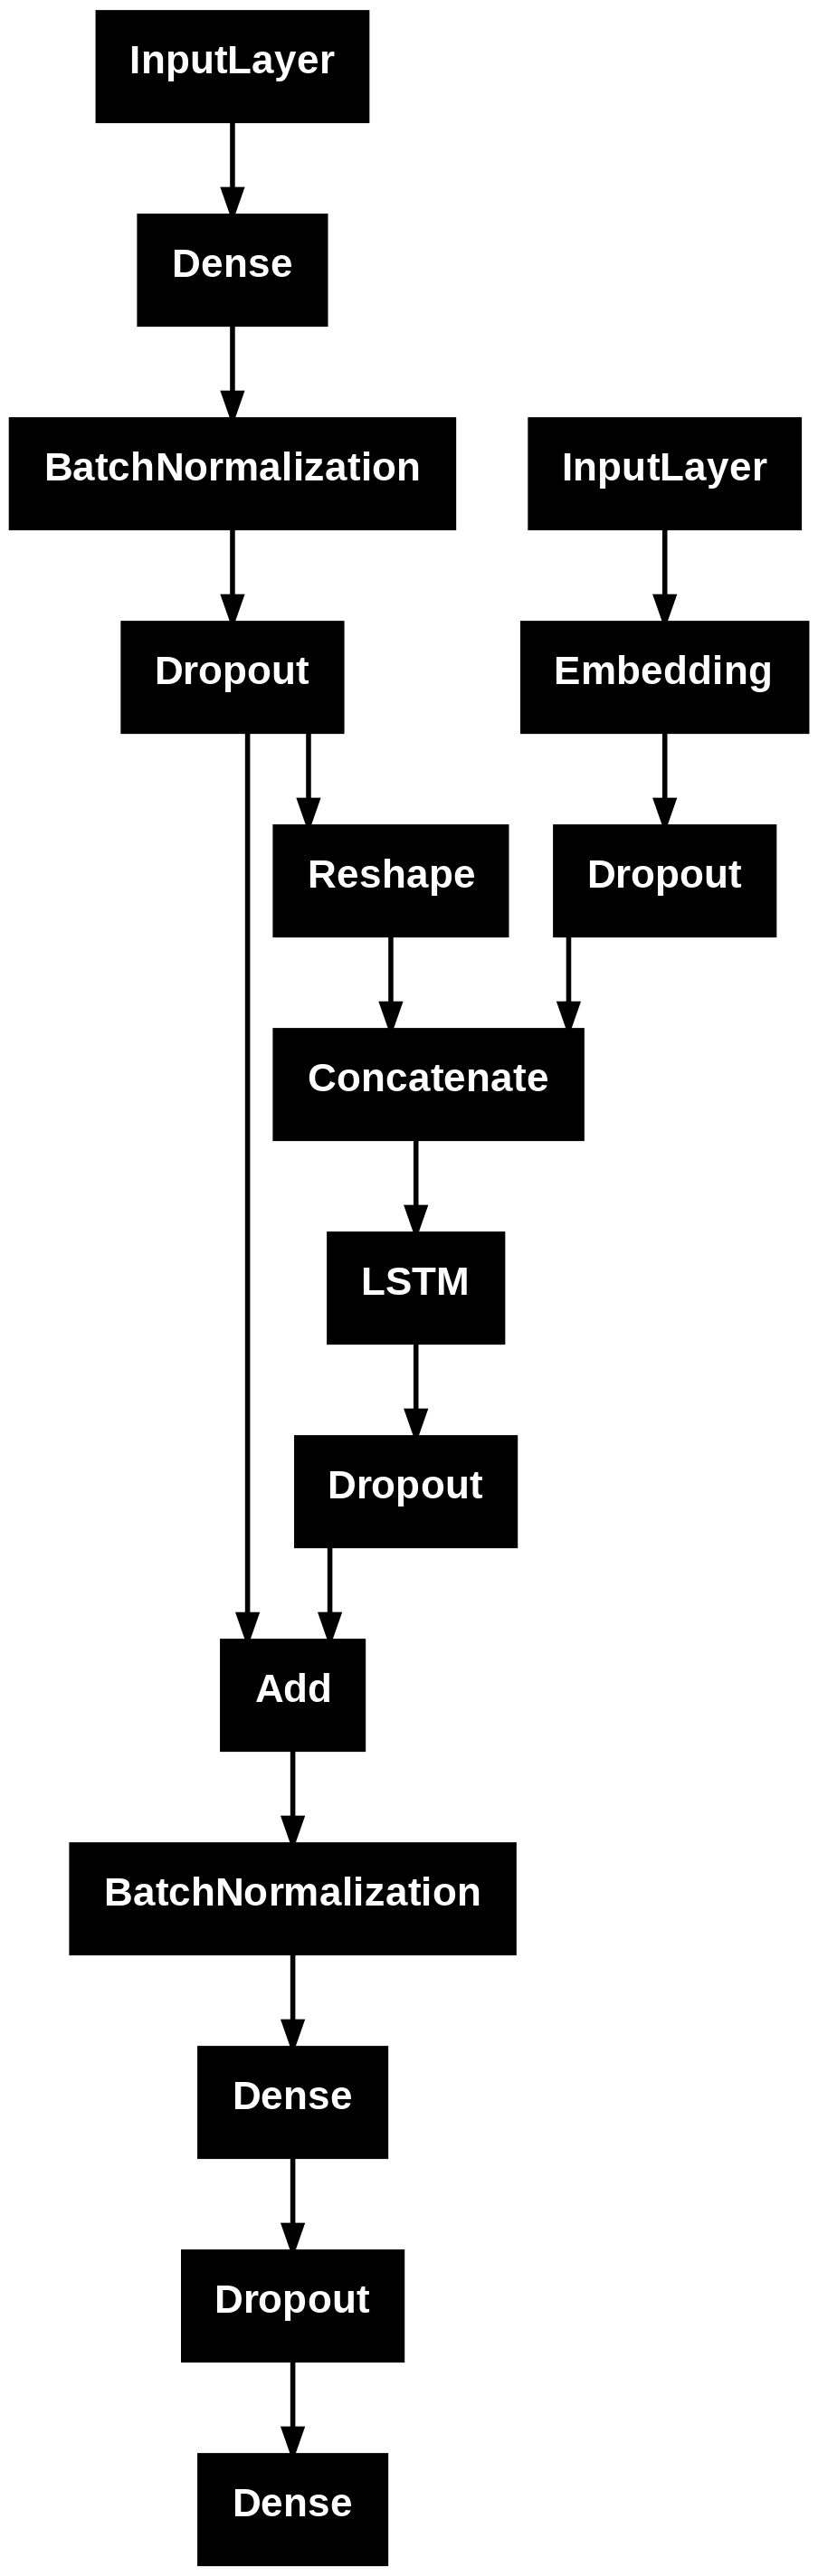

In [58]:
from tensorflow.keras.utils import plot_model

plot_model(caption_model)

In [59]:
from tensorflow.keras.callbacks import EarlyStopping ,ModelCheckpoint,ReduceLROnPlateau

In [60]:
model_name='captioner.h5'
callbacks = [
    ModelCheckpoint('captioner_best.h5', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.5, min_lr=1e-7, verbose=1)
]

In [65]:
hist = caption_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=150,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/150
859/859 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 4.5692
Epoch 1: val_loss improved from inf to 4.04284, saving model to captioner_best.h5


859/859 ━━━━━━━━━━━━━━━━━━━━ 166s 194ms/step - loss: 4.5690 - val_loss: 4.0428 - learning_rate: 0.0010
Epoch 2/150
859/859 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 4.0047
Epoch 2: val_loss improved from 4.04284 to 3.85332, saving model to captioner_best.h5


859/859 ━━━━━━━━━━━━━━━━━━━━ 165s 192ms/step - loss: 4.0046 - val_loss: 3.8533 - learning_rate: 0.0010
Epoch 3/150
859/859 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 3.7881
Epoch 3: val_loss improved from 3.85332 to 3.78227, saving model to captioner_best.h5


859/859 ━━━━━━━━━━━━━━━━━━━━ 172s 200ms/step - loss: 3.7881 - val_loss: 3.7823 - learning_rate: 0.0010
Epoch 4/150
859/859 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 3.6553
Epoch 4: val_loss improved from 3.78227 to 3.69130, saving model to captioner_best.h5


859/859 ━━━━━━━━━━━━━━━━━━━━ 193s 190ms/step - loss: 3.6553 - val_loss: 3.6913 - learning_rate: 0.0010
Epoch 5/150
859/859 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 3.5727
Epoch 5: val_loss improved from 3.69130 to 3.64687, saving model to captioner_best.h5


859/859 ━━━━━━━━━━━━━━━━━━━━ 175s 204ms/step - loss: 3.5727 - val_loss: 3.6469 - learning_rate: 0.0010
Epoch 6/150
859/859 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 3.5033
Epoch 6: val_loss improved from 3.64687 to 3.62597, saving model to captioner_best.h5


859/859 ━━━━━━━━━━━━━━━━━━━━ 165s 192ms/step - loss: 3.5033 - val_loss: 3.6260 - learning_rate: 0.0010
Epoch 7/150
859/859 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 3.4367
Epoch 7: val_loss improved from 3.62597 to 3.62111, saving model to captioner_best.h5


859/859 ━━━━━━━━━━━━━━━━━━━━ 174s 202ms/step - loss: 3.4367 - val_loss: 3.6211 - learning_rate: 0.0010
Epoch 8/150
859/859 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 3.3957
Epoch 8: val_loss did not improve from 3.62111
859/859 ━━━━━━━━━━━━━━━━━━━━ 169s 196ms/step - loss: 3.3957 - val_loss: 3.6574 - learning_rate: 0.0010
Epoch 9/150
859/859 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 3.3464
Epoch 9: val_loss did not improve from 3.62111
859/859 ━━━━━━━━━━━━━━━━━━━━ 176s 205ms/step - loss: 3.3465 - val_loss: 3.6335 - learning_rate: 0.0010
Epoch 10/150
859/859 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 3.3148
Epoch 10: val_loss improved from 3.62111 to 3.58535, saving model to captioner_best.h5


859/859 ━━━━━━━━━━━━━━━━━━━━ 169s 196ms/step - loss: 3.3148 - val_loss: 3.5853 - learning_rate: 0.0010
Epoch 11/150
859/859 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 3.2760
Epoch 11: val_loss did not improve from 3.58535
859/859 ━━━━━━━━━━━━━━━━━━━━ 167s 194ms/step - loss: 3.2760 - val_loss: 3.6135 - learning_rate: 0.0010
Epoch 12/150
859/859 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 3.2532
Epoch 12: val_loss did not improve from 3.58535
859/859 ━━━━━━━━━━━━━━━━━━━━ 168s 195ms/step - loss: 3.2532 - val_loss: 3.6697 - learning_rate: 0.0010
Epoch 13/150
859/859 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 3.2342
Epoch 13: val_loss did not improve from 3.58535
859/859 ━━━━━━━━━━━━━━━━━━━━ 172s 200ms/step - loss: 3.2342 - val_loss: 3.7468 - learning_rate: 0.0010
Epoch 14/150
859/859 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 3.2119
Epoch 14: val_loss did not improve from 3.58535

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
859/859 ━━━━━━━━━━━━━━━━━━━━ 166s 

KeyboardInterrupt: 

# Inference

In [66]:
from google.colab import files

files.download("captioner.h5")

FileNotFoundError: Cannot find file: captioner.h5

In [67]:
#seeing learning curve

plt.figure(figsize=(20,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.title("model's loss")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: name 'hist' is not defined

<Figure size 2000x800 with 0 Axes>

# TESTING

In [68]:
# first fn to predict

def i2w(i,tokenizer):
  for word,index in tokenizer.word_index.items():
    if index==i:
      return word
  return None

In [69]:
def predict(model, image, tokenizer, m_len, features, temperature=0.7):
    feature = features[image]
    in_text = "startseq"

    for i in range(m_len):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], m_len)

        y_pred = model.predict([feature, sequence], verbose=0)


        if temperature > 0:
            y_pred = np.log(y_pred + 1e-8) / temperature
            y_pred = np.exp(y_pred) / np.sum(np.exp(y_pred))

        # Sample from distribution instead of always taking max
        y_pred = np.random.choice(len(y_pred[0]), p=y_pred[0])

        word = i2w(y_pred, tokenizer)

        if word is None or word == 'endseq':
            break

        in_text += " " + word

    return in_text.replace('startseq', '').replace('endseq', '').strip()


# TEST

Image :


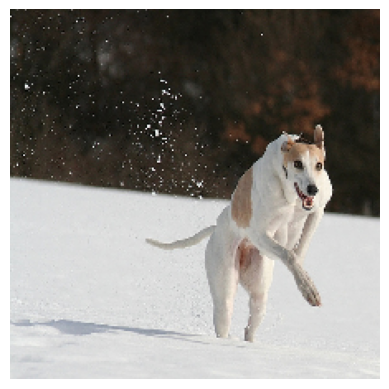

Caption :  a man in a yellow dress and a black sweatshirt with a beard is playing in a rocky garden


In [70]:
img_path = "/content/Images/101654506_8eb26cfb60.jpg"  # Added: actual image path
img=load_img(img_path,target_size=(224,224))
img=img_to_array(img)
img=img/255.

# Added: Extract features for test image
img_expanded = np.expand_dims(img, axis=0)
test_feature = feature_extractor.predict(img_expanded, verbose=0)
test_features = {"test_image": test_feature}

caption=predict(caption_model, "test_image", tokenizer, max_len_sentence, test_features)
print("Image :")
plt.imshow(img)
plt.axis("off")
plt.show()
print("Caption : ",caption)

In [ ]:
import pickle

with open("features.pkl", "wb") as f:
    pickle.dump(features, f)


In [ ]:
from google.colab import files

files.download("captioner.h5")
files.download("features.pkl")
